In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
# Download and loading CIFAR10 dataset for train and test

# Transformers for Images in the dataset, for creating new data with existing ones.
transformer_train = torchvision.transforms.Compose([
                        transforms.RandomCrop(32, padding=4),
                        torchvision.transforms.RandomHorizontalFlip(p=0.5),
                        torchvision.transforms.RandomAffine(0, translate=(0.1, 0.1)),
                        transforms.ToTensor()
                    ])

train_dataset = torchvision.datasets.CIFAR10(
                    root='.',
                    train=True,
                    transform=transformer_train,
                    download=True
                )

test_dataset = torchvision.datasets.CIFAR10(
                    root='.',
                    train=False,
                    transform=transforms.ToTensor(),
                    download=True
                )

100%|██████████| 170498071/170498071 [00:01<00:00, 94420410.85it/s] 


Extracting ./cifar-10-python.tar.gz to .
Files already downloaded and verified


In [3]:
train_dataset.data.shape           # 50000 data

(50000, 32, 32, 3)

In [4]:
train_dataset.data[0].shape        # 32 * 32 color images

(32, 32, 3)

In [5]:
# The CIFAR-10 dataset contains 60,000 32x32 color images in 10 different classes.
# The 10 different classes represent
# 1: airplanes, 2: cars, 3: birds, 4: cats, 5: deer, 6: dogs, 7: frogs, 8: horses, 9: ships, and 10: trucks

K = len(set(train_dataset.targets))
print("Number of Classes:", K)

Number of Classes: 10


In [6]:
batch_size = 128
train_loader = torch.utils.data.DataLoader(
                  dataset=train_dataset,
                  batch_size=batch_size,
                  shuffle=True
              )
test_loader = torch.utils.data.DataLoader(
                  dataset=test_dataset,
                  batch_size=batch_size,
                  shuffle=False
              )

In [7]:
train_dataset_fixed = torchvision.datasets.CIFAR10(
                          root='.',
                          train=True,
                          transform=transforms.ToTensor(),
                          download=True
                      )
train_loader_fixed = torch.utils.data.DataLoader(
                          dataset=train_dataset_fixed,
                          batch_size=batch_size,
                          shuffle=False
                      )

Files already downloaded and verified


In [ ]:
for x, y in train_loader_fixed:
  print(x)
  print(x.shape)
  break

In [9]:
tmp_loader = torch.utils.data.DataLoader(
                dataset=train_dataset,
                batch_size=1,
                shuffle=True
            )

for x, y in tmp_loader:
  # print(x)
  print(x.shape)
  break

torch.Size([1, 3, 32, 32])


In [10]:
class CNN(nn.Module):
  def __init__(self, K):
    super(CNN, self).__init__()

    self.conv1 = nn.Sequential(
        nn.Conv2d(3, 32, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.Conv2d(32, 32, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.MaxPool2d(2),
    )
    self.conv2 = nn.Sequential(
        nn.Conv2d(32, 64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.Conv2d(64, 64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.MaxPool2d(2),
    )
    self.conv3 = nn.Sequential(
        nn.Conv2d(64, 128, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(128),
        nn.Conv2d(128, 128, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(128),
        nn.MaxPool2d(2),
    )
    self.fc1 = nn.Linear(128 * 4 * 4, 1024)
    self.fc2 = nn.Linear(1024, K)

  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = x.view(x.size(0), -1)
    x = F.dropout(x, p=0.5)
    x = F.relu(self.fc1(x))
    x = F.dropout(x, p=0.2)
    x = self.fc2(x)
    return x


In [11]:
model = CNN(K)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [14]:
def batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs):
  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  for it in range(epochs):
    model.train()
    t0 = datetime.now()
    train_loss = []
    for inputs, targets in train_loader:
      # move data to GPU
      inputs, targets = inputs.to(device), targets.to(device)

      # zero the parameter gradients
      optimizer.zero_grad()

      # Forward pass
      outputs = model(inputs)
      loss = criterion(outputs, targets)

      # Backward and optimize
      loss.backward()
      optimizer.step()

      train_loss.append(loss.item())

    # Get train loss and test loss
    train_loss = np.mean(train_loss)

    model.eval()
    test_loss = []
    for inputs, targets in test_loader:
      inputs, targets = inputs.to(device), targets.to(device)
      outputs = model(inputs)
      loss = criterion(outputs, targets)
      test_loss.append(loss.item())
    test_loss = np.mean(test_loss)

    # Save losses
    train_losses[it] = train_loss
    test_losses[it] = test_loss

    dt = datetime.now() - t0
    print(f'Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, \
      Test Loss: {test_loss:.4f}, Duration: {dt}')

  return train_losses, test_losses

In [15]:
train_losses, test_losses = batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs=80)

Epoch 1/80, Train Loss: 1.4956,       Test Loss: 1.1488, Duration: 0:00:28.996738
Epoch 2/80, Train Loss: 1.0364,       Test Loss: 0.9097, Duration: 0:00:28.002637
Epoch 3/80, Train Loss: 0.8574,       Test Loss: 0.7845, Duration: 0:00:28.114540
Epoch 4/80, Train Loss: 0.7623,       Test Loss: 0.7216, Duration: 0:00:27.707501
Epoch 5/80, Train Loss: 0.6864,       Test Loss: 0.7257, Duration: 0:00:28.546154
Epoch 6/80, Train Loss: 0.6436,       Test Loss: 0.6636, Duration: 0:00:27.731264
Epoch 7/80, Train Loss: 0.6084,       Test Loss: 0.5939, Duration: 0:00:27.659649
Epoch 8/80, Train Loss: 0.5752,       Test Loss: 0.5554, Duration: 0:00:28.472246
Epoch 9/80, Train Loss: 0.5456,       Test Loss: 0.6155, Duration: 0:00:27.883027
Epoch 10/80, Train Loss: 0.5291,       Test Loss: 0.6261, Duration: 0:00:28.032274
Epoch 11/80, Train Loss: 0.5067,       Test Loss: 0.5684, Duration: 0:00:28.410033
Epoch 12/80, Train Loss: 0.4891,       Test Loss: 0.5227, Duration: 0:00:27.878886
Epoch 13/80, 

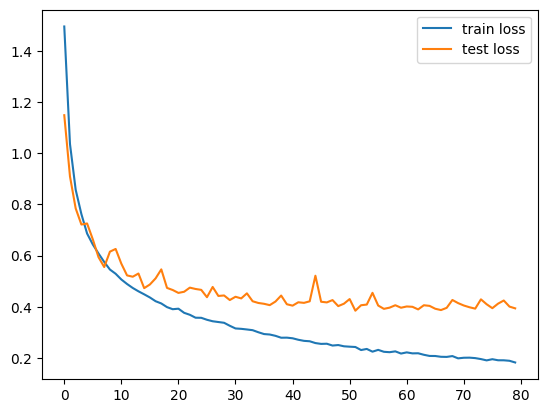

In [16]:
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [17]:
model.eval()
n_correct = 0.
n_total = 0.
for inputs, targets in train_loader_fixed:
  # Move to GPU
  inputs, targets = inputs.to(device), targets.to(device)

  # Forward pass
  outputs = model(inputs)

  # Get prediction
  # torch.max returns both max and argmax
  _, predictions = torch.max(outputs, 1)

  # update counts
  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]

train_acc = n_correct / n_total


n_correct = 0.
n_total = 0.
for inputs, targets in test_loader:
  # Move to GPU
  inputs, targets = inputs.to(device), targets.to(device)

  # Forward pass
  outputs = model(inputs)

  # Get prediction
  # torch.max returns both max and argmax
  _, predictions = torch.max(outputs, 1)

  # update counts
  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]

test_acc = n_correct / n_total
print(f"Train acc: {train_acc:.4f}, Test acc: {test_acc:.4f}")

Train acc: 0.9512, Test acc: 0.8808


In [18]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  print(cm)

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

Confusion matrix, without normalization
[[842   7  75   7   6   1   4   9  39  10]
 [  5 964   1   3   0   0   1   1   4  21]
 [ 11   1 899  11  30  15  22   5   5   1]
 [  7   6  70 700  48 106  31  16   5  11]
 [  2   0  50   8 901  12  11  15   1   0]
 [  5   1  39  69  26 830  10  19   1   0]
 [  3   2  38   9  21   7 913   4   2   1]
 [  3   1  27  17  30  25   1 893   1   2]
 [ 35  14  10   5   2   0   2   2 921   9]
 [ 11  48   3  10   0   0   4   0   7 917]]


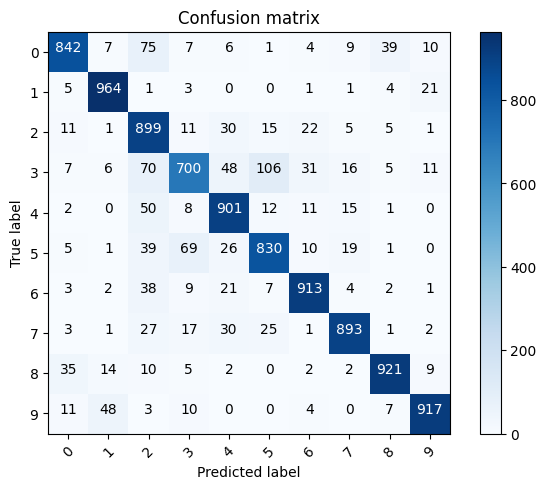

In [19]:
x_test = test_dataset.data
y_test = np.array(test_dataset.targets)
p_test = np.array([])
for inputs, targets in test_loader:
  # Move to GPU
  inputs, targets = inputs.to(device), targets.to(device)

  # Forward pass
  outputs = model(inputs)

  # Get prediction
  _, predictions = torch.max(outputs, 1)

  # update p_test
  p_test = np.concatenate((p_test, predictions.cpu().numpy()))

cm = confusion_matrix(y_test, p_test)
plot_confusion_matrix(cm, list(range(10)))

In [ ]:
model.state_dict()

In [21]:
torch.save(model.state_dict(), 'cifar10-cnn.pt')

In [22]:
from torchsummary import summary
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
              ReLU-2           [-1, 32, 32, 32]               0
       BatchNorm2d-3           [-1, 32, 32, 32]              64
            Conv2d-4           [-1, 32, 32, 32]           9,248
              ReLU-5           [-1, 32, 32, 32]               0
       BatchNorm2d-6           [-1, 32, 32, 32]              64
         MaxPool2d-7           [-1, 32, 16, 16]               0
            Conv2d-8           [-1, 64, 16, 16]          18,496
              ReLU-9           [-1, 64, 16, 16]               0
      BatchNorm2d-10           [-1, 64, 16, 16]             128
           Conv2d-11           [-1, 64, 16, 16]          36,928
             ReLU-12           [-1, 64, 16, 16]               0
      BatchNorm2d-13           [-1, 64, 16, 16]             128
        MaxPool2d-14             [-1, 6

In [40]:
from PIL import Image

model.eval()

transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

image_path = './test_image_2.jpg'
image = Image.open(image_path)
input_tensor = transform(image)
input_batch = input_tensor.unsqueeze(0)

# Make prediction
with torch.no_grad():
    output = model(input_batch.to(device))

# Get predicted class
_, predicted_class = torch.max(output, 1)
print(f"Predicted class index: {predicted_class}")

Predicted class index: tensor([8], device='cuda:0')
